# HIPS and FTIR Data Analysis
# =========================== 
This notebook provides a modular analysis workflow for comparing HIPS (Hybrid Integrating Plate/Sphere) and FTIR (Fourier Transform Infrared Spectroscopy) measurements of black carbon and elemental carbon.

## Setup and Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
import os
from datetime import datetime

# Set plot style
plt.style.use('default')
sns.set_theme()
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100

# Optional: Create output directory
output_dir = 'output/hips_analysis'
os.makedirs(output_dir, exist_ok=True)

## Data Loading Functions

In [2]:
def load_etad_data(filepath):
    """Load and preprocess ETAD (HIPS) data"""
    print(f"Loading ETAD (HIPS) data from {filepath}...")
    etad_data = pd.read_csv(filepath)
    etad_data['SampleDate'] = pd.to_datetime(etad_data['SampleDate'])
    print(f"Loaded {len(etad_data)} ETAD (HIPS) samples")
    
    # Display the first few rows
    display(etad_data.head())
    
    return etad_data

def load_ftir_data(filepaths):
    """Load and combine FTIR data from multiple batches"""
    print(f"Loading FTIR data from {len(filepaths)} files...")
    
    dataframes = []
    for filepath in filepaths:
        print(f"  - Reading {filepath}")
        df = pd.read_csv(filepath)
        dataframes.append(df)
    
    combined_df = pd.concat(dataframes, ignore_index=True)
    combined_df['date'] = pd.to_datetime(combined_df['date'])
    print(f"Loaded {len(combined_df)} total FTIR samples")
    
    # Display the first few rows
    display(combined_df.head())
    
    return combined_df

## Load Data
 
Use this cell to load your ETAD (HIPS) and FTIR data files.

In [3]:
# Define filepaths - update these with your actual paths
etad_data_path = "/Users/ahzs645/Library/CloudStorage/GoogleDrive-ahzs645@gmail.com/My Drive/University/Research/Grad/UC Davis Ann/NASA MAIA/Data/EC-HIPS-Aeth Comparison/Data/Original Data/HIPS BC/ETAD_data_2023.csv"  # Update with your path
ftir_data_paths = [
    "/Users/ahzs645/Library/CloudStorage/GoogleDrive-ahzs645@gmail.com/My Drive/University/Research/Grad/UC Davis Ann/NASA MAIA/Data/EC-HIPS-Aeth Comparison/Data/Original Data/FTIR EC/SPARTAN_FTIR data batch 2 and 3 resubmitted with MDLs.csv",  # Update with your path
    "/Users/ahzs645/Library/CloudStorage/GoogleDrive-ahzs645@gmail.com/My Drive/University/Research/Grad/UC Davis Ann/NASA MAIA/Data/EC-HIPS-Aeth Comparison/Data/Original Data/FTIR EC/SPARTAN_FTIR data_batch 4_ Nov2022 to March2024.csv"  # Update with your path
]

# Load ETAD (HIPS) data
etad_data = load_etad_data(etad_data_path)

# Load FTIR data
ftir_data = load_ftir_data(ftir_data_paths)

Loading ETAD (HIPS) data from /Users/ahzs645/Library/CloudStorage/GoogleDrive-ahzs645@gmail.com/My Drive/University/Research/Grad/UC Davis Ann/NASA MAIA/Data/EC-HIPS-Aeth Comparison/Data/Original Data/HIPS BC/ETAD_data_2023.csv...
Loaded 108 ETAD (HIPS) samples


,Site,Latitude,Longitude,Barcode,FilterId,SampleDate,FilterType,LotId,T1,R1,...,t,r,tau,DepositArea,Volume,Fabs,MDL,Uncertainty,AnalysisComments,FilterComments
0,ETAD,9.0106,38.8207,E52849,ETAD-0001-1,2023-01-21,PM2.5,248,348,138,...,0.251591,0.253811,1.087175,3.53,6.9408,55.292322,1.627478,3.393087,NaN,NaN
1,ETAD,9.0106,38.8207,E52866,ETAD-0002-2,2023-01-24,PM2.5,248,415,155,...,0.300029,0.285078,0.868294,3.53,6.9408,44.160320,1.627478,2.743621,NaN,NaN
2,ETAD,9.0106,38.8207,E52895,ETAD-0003-3,2023-01-27,PM2.5,248,462,164,...,0.334008,0.301631,0.737582,3.53,6.9408,37.512474,1.627478,2.360687,NaN,NaN
3,ETAD,9.0106,38.8207,E52897,ETAD-0004-4,2023-01-30,PM2.5,248,426,165,...,0.307981,0.303470,0.816071,3.53,7.0272,40.993997,1.607468,2.558205,NaN,NaN
4,ETAD,9.0106,38.8207,E52872,ETAD-0005-5,2023-02-02,PM2.5,248,404,145,...,0.292076,0.266686,0.920559,3.53,7.0272,46.242781,1.607468,2.862308,NaN,NaN


Loading FTIR data from 2 files...
  - Reading /Users/ahzs645/Library/CloudStorage/GoogleDrive-ahzs645@gmail.com/My Drive/University/Research/Grad/UC Davis Ann/NASA MAIA/Data/EC-HIPS-Aeth Comparison/Data/Original Data/FTIR EC/SPARTAN_FTIR data batch 2 and 3 resubmitted with MDLs.csv
  - Reading /Users/ahzs645/Library/CloudStorage/GoogleDrive-ahzs645@gmail.com/My Drive/University/Research/Grad/UC Davis Ann/NASA MAIA/Data/EC-HIPS-Aeth Comparison/Data/Original Data/FTIR EC/SPARTAN_FTIR data_batch 4_ Nov2022 to March2024.csv
Loaded 2544 total FTIR samples


,sample,site,network,date,volume,aCOH,aCH,naCO,COOH,OM,FTIR_OC,OC MDL,FTIR_EC,EC MDL,Unnamed: 14
0,Tensor II_SN151_S_AEAZ_0089_1_PM25_10_08_2020_...,AEAZ,S,2020-10-08,7.42,2.13,27.13,0.00,23.38,52.64,-3.90,0.5,4.59,0.27,Data reported with high uncertainty
1,Tensor II_SN151_S_AEAZ_0090_2_PM25_10_17_2020_...,AEAZ,S,2020-10-17,7.42,4.70,17.50,0.00,19.37,41.56,3.22,0.5,5.48,0.27,Data reported with high uncertainty
2,Tensor II_SN151_S_AEAZ_0091_3_PM25_10_26_2020_...,AEAZ,S,2020-10-26,7.42,5.64,24.48,0.00,21.71,51.83,37.73,0.5,15.22,0.27,Data reported with high uncertainty
3,Tensor II_SN151_S_AEAZ_0092_4_PM25_11_04_2020_...,AEAZ,S,2020-11-04,7.34,4.76,32.49,0.00,31.30,68.54,18.14,0.5,14.71,0.27,Data reported with high uncertainty
4,Tensor II_SN151_S_AEAZ_0093_5_PM25_11_13_2020_...,AEAZ,S,2020-11-13,7.34,5.12,8.11,1.51,6.68,21.41,17.67,0.5,14.45,0.27,Data reported with high uncertainty


## Data Preprocessing Functions

In [4]:
def create_season_column(df, date_column='SampleDate'):
    """Add season column based on month"""
    print("Creating season classifications...")
    
    # Define seasons for our analysis based on requirements
    def get_season(month):
        if month in [1, 2]:
            return 'Jan-Feb'
        elif month in [3, 4]:
            return 'Mar-Apr'
        elif month in [5, 6, 7, 8, 9]:
            return 'May-Sept'
        else:  # 10, 11, 12
            return 'Oct-Dec'
    
    # Extract month from the date column
    if isinstance(df[date_column].iloc[0], pd.Timestamp):
        df['Month'] = df[date_column].dt.month
    else:
        df['Month'] = pd.to_datetime(df[date_column]).dt.month
    
    # Apply the season mapping
    df['Season'] = df['Month'].apply(get_season)
    
    # Show seasonal distribution
    season_counts = df['Season'].value_counts()
    print("Samples per season:")
    display(season_counts)
    
    return df

def match_etad_ftir_data(etad_data, ftir_data, site='ETAD'):
    """Match ETAD (HIPS) and FTIR data for analysis"""
    print(f"Matching ETAD (HIPS) and FTIR data for site: {site}...")
    
    # Filter data for the specified site
    etad_filtered = etad_data[etad_data['Site'] == site].copy()
    ftir_filtered = ftir_data[ftir_data['site'] == site].copy()
    
    print(f"ETAD (HIPS) samples for site {site}: {len(etad_filtered)}")
    print(f"FTIR samples for site {site}: {len(ftir_filtered)}")
    
    # Initialize combined dataset
    analysis_data = etad_filtered.copy()
    analysis_data['FTIR_EC'] = np.nan
    
    # Match samples by date
    matches_found = 0
    for idx, row in analysis_data.iterrows():
        matching_ftir = ftir_filtered[
            (ftir_filtered['date'] == row['SampleDate']) &
            (ftir_filtered['site'] == site)
        ]
        if not matching_ftir.empty:
            analysis_data.at[idx, 'FTIR_EC'] = matching_ftir.iloc[0]['FTIR_EC']
            matches_found += 1
    
    print(f"Matches found: {matches_found} out of {len(analysis_data)} ETAD samples")
    
    # Show the first few rows of the matched data
    display(analysis_data.head())
    
    return analysis_data

def clean_analysis_data(analysis_data):
    """Clean and prepare data for analysis"""
    print("Cleaning and preparing data for analysis...")
    
    # Convert columns to numeric
    analysis_data['FTIR_EC'] = pd.to_numeric(analysis_data['FTIR_EC'], errors='coerce')
    analysis_data['Fabs'] = pd.to_numeric(analysis_data['Fabs'], errors='coerce')
    
    # Check for missing values
    missing_count = {
        'FTIR_EC': analysis_data['FTIR_EC'].isna().sum(),
        'Fabs': analysis_data['Fabs'].isna().sum()
    }
    print(f"Missing values: {missing_count}")
    
    # Remove rows with missing values
    clean_data = analysis_data.dropna(subset=['FTIR_EC', 'Fabs'])
    print(f"Final clean data points: {len(clean_data)} out of {len(analysis_data)} matched samples")
    
    # Basic statistics of the clean data
    print("\nBasic statistics of the clean data:")
    display(clean_data[['FTIR_EC', 'Fabs']].describe())
    
    return clean_data

## Preprocess Data
 
Use this cell to match and clean your ETAD (HIPS) and FTIR data.

In [5]:
# Match ETAD (HIPS) and FTIR data
analysis_data = match_etad_ftir_data(etad_data, ftir_data)

# Clean data
clean_data = clean_analysis_data(analysis_data)

# Add season column
clean_data = create_season_column(clean_data)

Matching ETAD (HIPS) and FTIR data for site: ETAD...
ETAD (HIPS) samples for site ETAD: 108
FTIR samples for site ETAD: 119
Matches found: 104 out of 108 ETAD samples


,Site,Latitude,Longitude,Barcode,FilterId,SampleDate,FilterType,LotId,T1,R1,...,r,tau,DepositArea,Volume,Fabs,MDL,Uncertainty,AnalysisComments,FilterComments,FTIR_EC
0,ETAD,9.0106,38.8207,E52849,ETAD-0001-1,2023-01-21,PM2.5,248,348,138,...,0.253811,1.087175,3.53,6.9408,55.292322,1.627478,3.393087,NaN,NaN,3.57
1,ETAD,9.0106,38.8207,E52866,ETAD-0002-2,2023-01-24,PM2.5,248,415,155,...,0.285078,0.868294,3.53,6.9408,44.160320,1.627478,2.743621,NaN,NaN,2.71
2,ETAD,9.0106,38.8207,E52895,ETAD-0003-3,2023-01-27,PM2.5,248,462,164,...,0.301631,0.737582,3.53,6.9408,37.512474,1.627478,2.360687,NaN,NaN,2.21
3,ETAD,9.0106,38.8207,E52897,ETAD-0004-4,2023-01-30,PM2.5,248,426,165,...,0.303470,0.816071,3.53,7.0272,40.993997,1.607468,2.558205,NaN,NaN,2.43
4,ETAD,9.0106,38.8207,E52872,ETAD-0005-5,2023-02-02,PM2.5,248,404,145,...,0.266686,0.920559,3.53,7.0272,46.242781,1.607468,2.862308,NaN,NaN,2.76


Cleaning and preparing data for analysis...
Missing values: {'FTIR_EC': np.int64(4), 'Fabs': np.int64(0)}
Final clean data points: 104 out of 108 matched samples

Basic statistics of the clean data:


,FTIR_EC,Fabs
count,104.000000,104.000000
mean,4.946447,48.461883
std,2.268399,10.082006
min,1.904433,30.340733
25%,3.283905,40.955371
50%,4.020457,46.522340
75%,6.738406,55.331895
max,10.533330,74.191711


Creating season classifications...
Samples per season:


/var/folders/5y/nymdg1zj29dglz6b4sf4v02c0000gn/T/ipykernel_26909/262319972.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Month'] = df[date_column].dt.month
/var/folders/5y/nymdg1zj29dglz6b4sf4v02c0000gn/T/ipykernel_26909/262319972.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Season'] = df['Month'].apply(get_season)


Season
May-Sept    46
Oct-Dec     22
Jan-Feb     18
Mar-Apr     18
Name: count, dtype: int64

## Analysis Functions

In [6]:
def calculate_mac_from_regression(clean_data):
    """Calculate MAC value from regression of Fabs vs FTIR_EC"""
    print("Calculating MAC value from regression analysis...")
    
    # Run regression analysis
    X = clean_data['FTIR_EC']
    y = clean_data['Fabs']
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    
    # Extract slope (MAC value)
    mac = model.params[1]
    intercept = model.params[0]
    r_squared = model.rsquared
    
    print(f"Regression Results:")
    print(f"MAC value (slope): {mac:.3f} m²/g")
    print(f"Intercept: {intercept:.3f}")
    print(f"R-squared: {r_squared:.3f}")
    
    # Display full regression summary
    print("\nDetailed Regression Summary:")
    display(model.summary())
    
    return {
        'mac': mac,
        'intercept': intercept,
        'r_squared': r_squared,
        'model': model
    }

def convert_fabs_to_bc(fabs, mac):
    """Convert Fabs (1/Mm) to BC (μg/m³) using MAC value"""
    return fabs / mac

## Calculate MAC and Convert Fabs to BC
 
Use this cell to calculate the MAC value from regression analysis and convert Fabs to BC.

In [7]:
# Calculate MAC from regression
regression_results = calculate_mac_from_regression(clean_data)
mac = regression_results['mac']

# Add BC values to the dataset for later use
clean_data_with_bc = clean_data.copy()
clean_data_with_bc['BC_HIPS'] = convert_fabs_to_bc(clean_data_with_bc['Fabs'], mac)

Calculating MAC value from regression analysis...
Regression Results:
MAC value (slope): 4.018 m²/g
Intercept: 28.586
R-squared: 0.817

Detailed Regression Summary:


/var/folders/5y/nymdg1zj29dglz6b4sf4v02c0000gn/T/ipykernel_26909/2505814612.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mac = model.params[1]
/var/folders/5y/nymdg1zj29dglz6b4sf4v02c0000gn/T/ipykernel_26909/2505814612.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept = model.params[0]


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Fabs   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     456.4
Date:                Mon, 05 May 2025   Prob (F-statistic):           1.92e-39
Time:                        13:36:38   Log-Likelihood:                -298.98
No. Observations:                 104   AIC:                             602.0
Df Residuals:                     102   BIC:                             607.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         28.5861      1.023     27.953      0.000      26.558      30.615
FTIR_EC        4.0182      0.188     21.364      0.000       3.645       4.391
==============================================================================
Omnibus:                        1.170   Durbin-Watson:                   1.708
Prob(Omnibus):                  0.557   Jarque-Bera (JB):                0.677
Skew:                           0.109   Prob(JB):                        0.713
Kurtosis:                       3.329   Cond. No.                         13.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Visualization Functions

In [17]:
def plot_regression(clean_data, regression_results, output_dir=None):
    """Create regression plot with statistics"""
    print("Creating regression plot of FTIR EC vs HIPS Fabs...")
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Create scatter plot
    sns.regplot(data=clean_data, x='FTIR_EC', y='Fabs', 
                scatter_kws={'alpha': 0.6}, line_kws={'color': 'red'}, ax=ax)
    
    # Add regression details
    mac = regression_results['mac']
    intercept = regression_results['intercept']
    r_squared = regression_results['r_squared']
    
    equation = f"Fabs = {mac:.2f} × FTIR_EC + {intercept:.2f}"
    stats_text = f"MAC = {mac:.2f} m²/g\nR² = {r_squared:.3f}\nn = {len(clean_data)}"
    
    # Add text box with statistics
    props = dict(boxstyle='round', facecolor='white', alpha=0.7)
    ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, 
            verticalalignment='top', bbox=props)
    
    # Add equation
    ax.text(0.05, 0.82, equation, transform=ax.transAxes, 
            verticalalignment='top', bbox=props)
    
    ax.set_title('FTIR EC vs HIPS Fabs with Regression Line')
    ax.set_xlabel('FTIR EC (μg/m³)')
    ax.set_ylabel('Fabs (1/Mm)')
    
    plt.tight_layout()
    
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
        plt.savefig(os.path.join(output_dir, 'ftir_ec_vs_hips_fabs_regression.png'), dpi=300)
    
    plt.show()
    return fig

def plot_time_series(clean_data, mac, output_dir=None):
    """Create time series plot with both original and converted values"""
    print("Creating time series plot of FTIR EC and HIPS BC...")
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Add calculated BC values
    data_to_plot = clean_data.copy()
    data_to_plot['BC_HIPS'] = convert_fabs_to_bc(data_to_plot['Fabs'], mac)
    
    # Plot FTIR_EC
    ax.plot(data_to_plot['SampleDate'], data_to_plot['FTIR_EC'], 'o-', 
            color='blue', label='FTIR EC')
    ax.set_xlabel('Date')
    ax.set_ylabel('Concentration (μg/m³)')
    
    # Plot BC_HIPS on the same y-axis
    ax.plot(data_to_plot['SampleDate'], data_to_plot['BC_HIPS'], 's--', 
            color='red', label='HIPS BC')
    
    # Common formatting
    plt.title('Time Series: FTIR EC vs HIPS BC')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
        plt.savefig(os.path.join(output_dir, 'ftir_ec_vs_hips_bc_time_series.png'), dpi=300)
    
    plt.show()
    return fig

def plot_bc_comparison(clean_data, mac, output_dir=None):
    """Create direct comparison scatter plot of FTIR EC vs HIPS BC"""
    print("Creating comparison plot of FTIR EC vs HIPS BC...")
    
    # Add calculated BC values
    data_to_plot = clean_data.copy()
    data_to_plot['BC_HIPS'] = convert_fabs_to_bc(data_to_plot['Fabs'], mac)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Create scatter plot
    sns.regplot(data=data_to_plot, x='FTIR_EC', y='BC_HIPS', 
                scatter_kws={'alpha': 0.6}, line_kws={'color': 'red'}, ax=ax)
    
    # Set limits to just cover the data range with a small buffer
    x_min = data_to_plot['FTIR_EC'].min() * 0.9  # Add 10% buffer below
    x_max = data_to_plot['FTIR_EC'].max() * 1.1  # Add 10% buffer above
    y_min = data_to_plot['BC_HIPS'].min() * 0.9
    y_max = data_to_plot['BC_HIPS'].max() * 1.1
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    
    # Calculate statistics
    r_value = data_to_plot['FTIR_EC'].corr(data_to_plot['BC_HIPS'])
    mean_bias = (data_to_plot['BC_HIPS'] - data_to_plot['FTIR_EC']).mean()
    rmse = np.sqrt(((data_to_plot['BC_HIPS'] - data_to_plot['FTIR_EC']) ** 2).mean())
    
    # Add text box with statistics
    stats_text = f"r = {r_value:.3f}\nMean Bias = {mean_bias:.2f} μg/m³\nRMSE = {rmse:.2f} μg/m³\nn = {len(data_to_plot)}"
    props = dict(boxstyle='round', facecolor='white', alpha=0.7)
    ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, 
            verticalalignment='top', bbox=props)
    
    ax.set_title('FTIR EC vs HIPS BC Comparison')
    ax.set_xlabel('FTIR EC (μg/m³)')
    ax.set_ylabel('HIPS BC (μg/m³)')
    
    plt.tight_layout()
    
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
        plt.savefig(os.path.join(output_dir, 'ftir_ec_vs_hips_bc_comparison.png'), dpi=300)
    
    plt.show()
    return fig


## Create Basic Visualizations

Use this cell to create regression and time series plots.

Creating regression plot of FTIR EC vs HIPS Fabs...


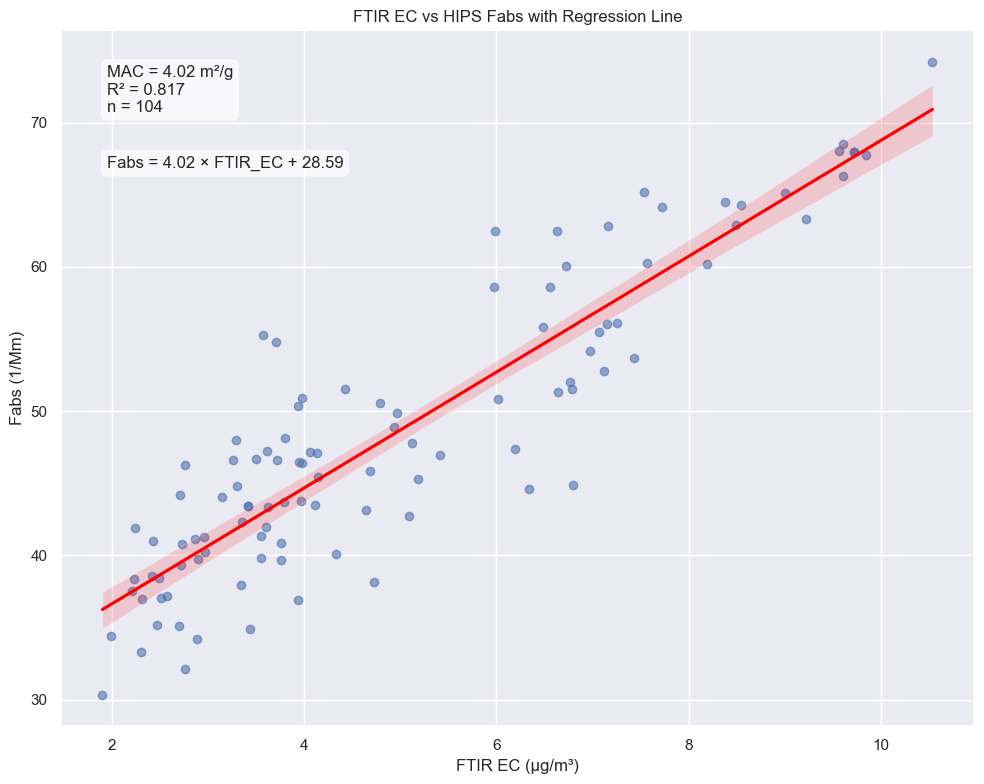

Creating time series plot of FTIR EC and HIPS BC...


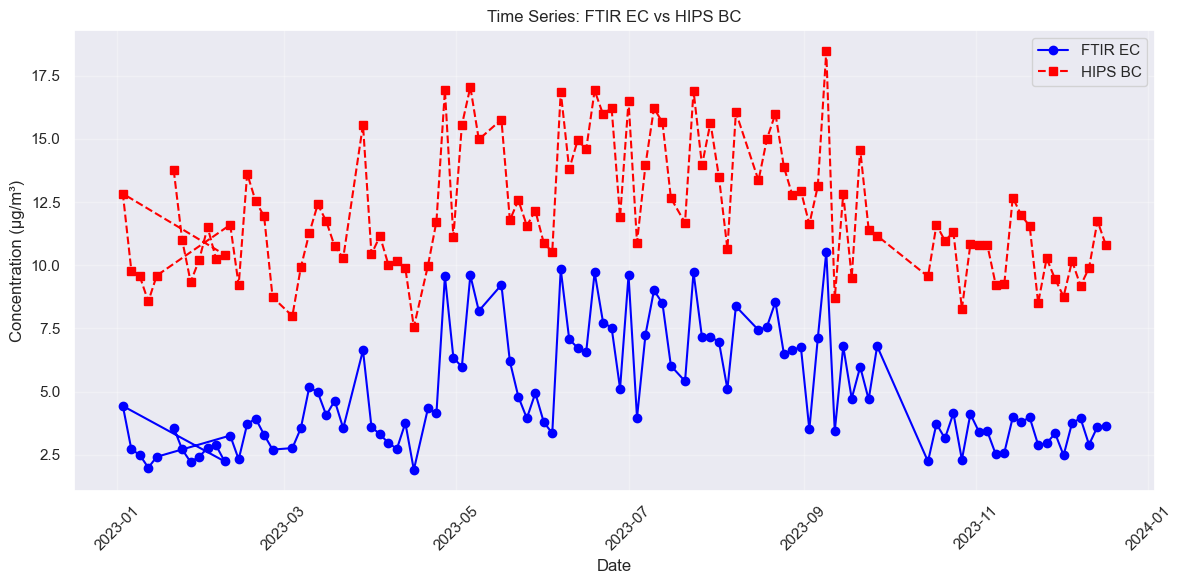

Creating comparison plot of FTIR EC vs HIPS BC...


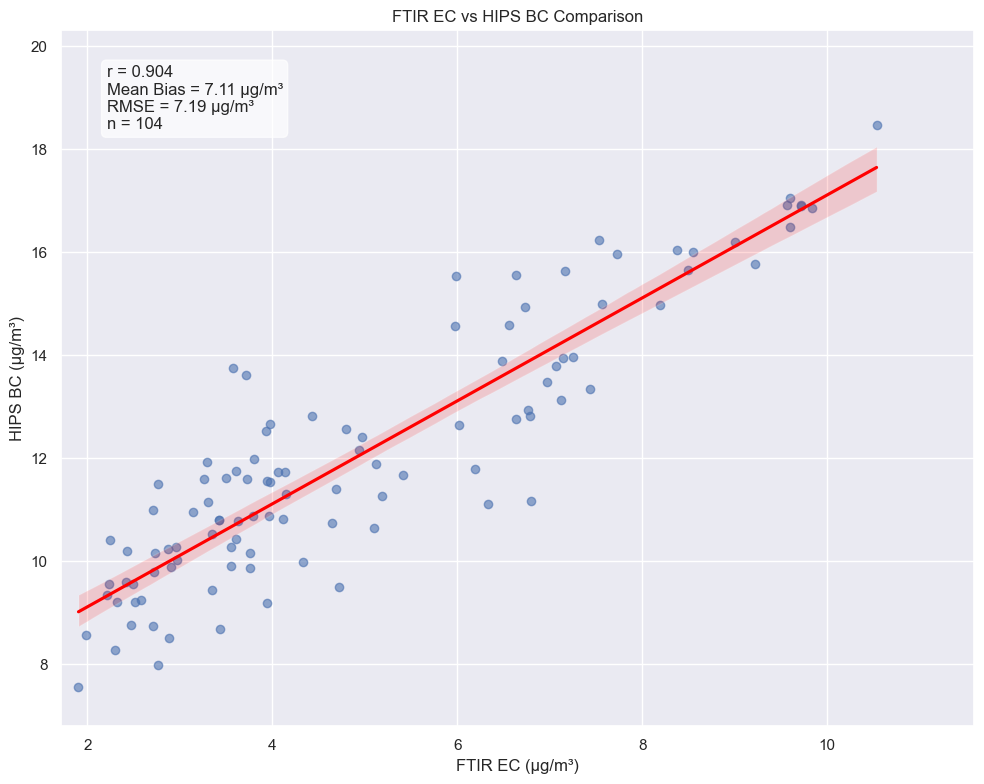

In [18]:
# Create regression plot
regression_plot = plot_regression(clean_data, regression_results, output_dir)

# Create time series plot
time_series_plot = plot_time_series(clean_data, mac, output_dir)

# Create comparison plot
comparison_plot = plot_bc_comparison(clean_data, mac, output_dir)

## Seasonal Analysis Functions

In [10]:
def analyze_seasonal_data(clean_data, mac, output_dir=None):
    """Analyze and plot data by season"""
    print("Performing seasonal analysis...")
    
    # Calculate BC values
    data_for_analysis = clean_data.copy()
    data_for_analysis['BC_HIPS'] = convert_fabs_to_bc(data_for_analysis['Fabs'], mac)
    
    # Order seasons correctly
    season_order = ['Jan-Feb', 'Mar-Apr', 'May-Sept', 'Oct-Dec']
    
    # Calculate seasonal statistics
    seasonal_stats = data_for_analysis.groupby('Season').agg({
        'FTIR_EC': ['count', 'mean', 'std'],
        'BC_HIPS': ['mean', 'std'],
        'Fabs': ['mean', 'std']
    })
    
    # Reorder the seasons
    seasonal_stats = seasonal_stats.reindex(season_order)
    
    print("\nSeasonal Statistics:")
    display(seasonal_stats)
    
    # Calculate correlations by season
    seasonal_correlations = data_for_analysis.groupby('Season').apply(
        lambda x: pd.Series({
            'Correlation': x['FTIR_EC'].corr(x['BC_HIPS']),
            'Sample Size': len(x)
        })
    )
    
    seasonal_correlations = seasonal_correlations.reindex(season_order)
    print("\nSeasonal Correlations:")
    display(seasonal_correlations)
    
    # Create seasonal box plots
    print("\nCreating seasonal box plots...")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Box plot for FTIR EC
    sns.boxplot(data=data_for_analysis, x='Season', y='FTIR_EC', 
                order=season_order, ax=ax1)
    ax1.set_title('FTIR EC by Season')
    ax1.set_xlabel('Season')
    ax1.set_ylabel('FTIR EC (μg/m³)')
    
    # Box plot for HIPS BC
    sns.boxplot(data=data_for_analysis, x='Season', y='BC_HIPS', 
                order=season_order, ax=ax2)
    ax2.set_title('HIPS BC by Season')
    ax2.set_xlabel('Season')
    ax2.set_ylabel('HIPS BC (μg/m³)')
    
    plt.tight_layout()
    
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
        plt.savefig(os.path.join(output_dir, 'seasonal_boxplots.png'), dpi=300)
    
    plt.show()
    
    # Create seasonal correlation plots
    print("\nCreating seasonal correlation plots...")
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()
    
    for i, season in enumerate(season_order):
        season_data = data_for_analysis[data_for_analysis['Season'] == season]
        if len(season_data) > 0:
            ax = axes[i]
            sns.regplot(data=season_data, x='FTIR_EC', y='BC_HIPS', 
                        scatter_kws={'alpha': 0.6}, ax=ax)
            
            # Calculate statistics for this season
            X = season_data['FTIR_EC']
            y = season_data['BC_HIPS']
            if len(X) > 1:  # Need at least 2 points for regression
                X = sm.add_constant(X)
                model = sm.OLS(y, X).fit()
                
                r_squared = model.rsquared
                slope = model.params[1]
                intercept = model.params[0]
                
                stats_text = f"Slope = {slope:.2f}\nIntercept = {intercept:.2f}\nR² = {r_squared:.3f}\nn = {len(season_data)}"
                props = dict(boxstyle='round', facecolor='white', alpha=0.7)
                ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, 
                        verticalalignment='top', bbox=props)
            
            ax.set_title(f'{season}')
            ax.set_xlabel('FTIR EC (μg/m³)')
            ax.set_ylabel('HIPS BC (μg/m³)')
    
    plt.tight_layout()
    
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
        plt.savefig(os.path.join(output_dir, 'seasonal_correlations.png'), dpi=300)
    
    plt.show()
    
    return {
        'seasonal_stats': seasonal_stats,
        'seasonal_correlations': seasonal_correlations
    }


## Perform Seasonal Analysis
 
Use this cell to analyze data by season.

Performing seasonal analysis...

Seasonal Statistics:


FTIR_EC                        BC_HIPS                 Fabs          
           count      mean       std       mean       std       mean       std
Season                                                                        
Jan-Feb       18  2.892308  0.669854  10.800682  1.629477  43.399128  6.547536
Mar-Apr       18  4.333374  1.781110  11.045611  2.249281  44.383296  9.038024
May-Sept      46  6.771913  1.918690  13.772468  2.307326  55.340311  9.271259
Oct-Dec       22  3.311830  0.616987  10.342731  1.212728  41.558994  4.872965


Seasonal Correlations:


/var/folders/5y/nymdg1zj29dglz6b4sf4v02c0000gn/T/ipykernel_26909/3565183437.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  seasonal_correlations = data_for_analysis.groupby('Season').apply(


,Correlation,Sample Size
Season,,
Jan-Feb,0.860727,18.0
Mar-Apr,0.888304,18.0
May-Sept,0.897019,46.0
Oct-Dec,0.733041,22.0



Creating seasonal box plots...


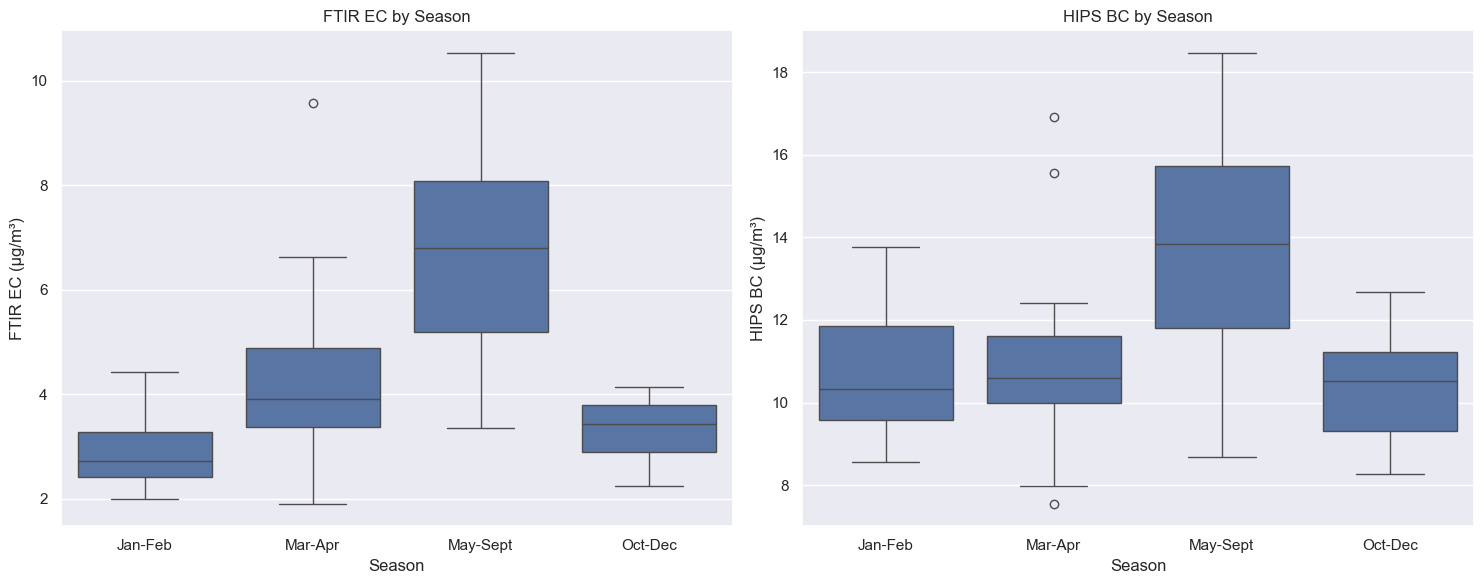


Creating seasonal correlation plots...


/var/folders/5y/nymdg1zj29dglz6b4sf4v02c0000gn/T/ipykernel_26909/3565183437.py:83: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope = model.params[1]
/var/folders/5y/nymdg1zj29dglz6b4sf4v02c0000gn/T/ipykernel_26909/3565183437.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept = model.params[0]
/var/folders/5y/nymdg1zj29dglz6b4sf4v02c0000gn/T/ipykernel_26909/3565183437.py:83: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

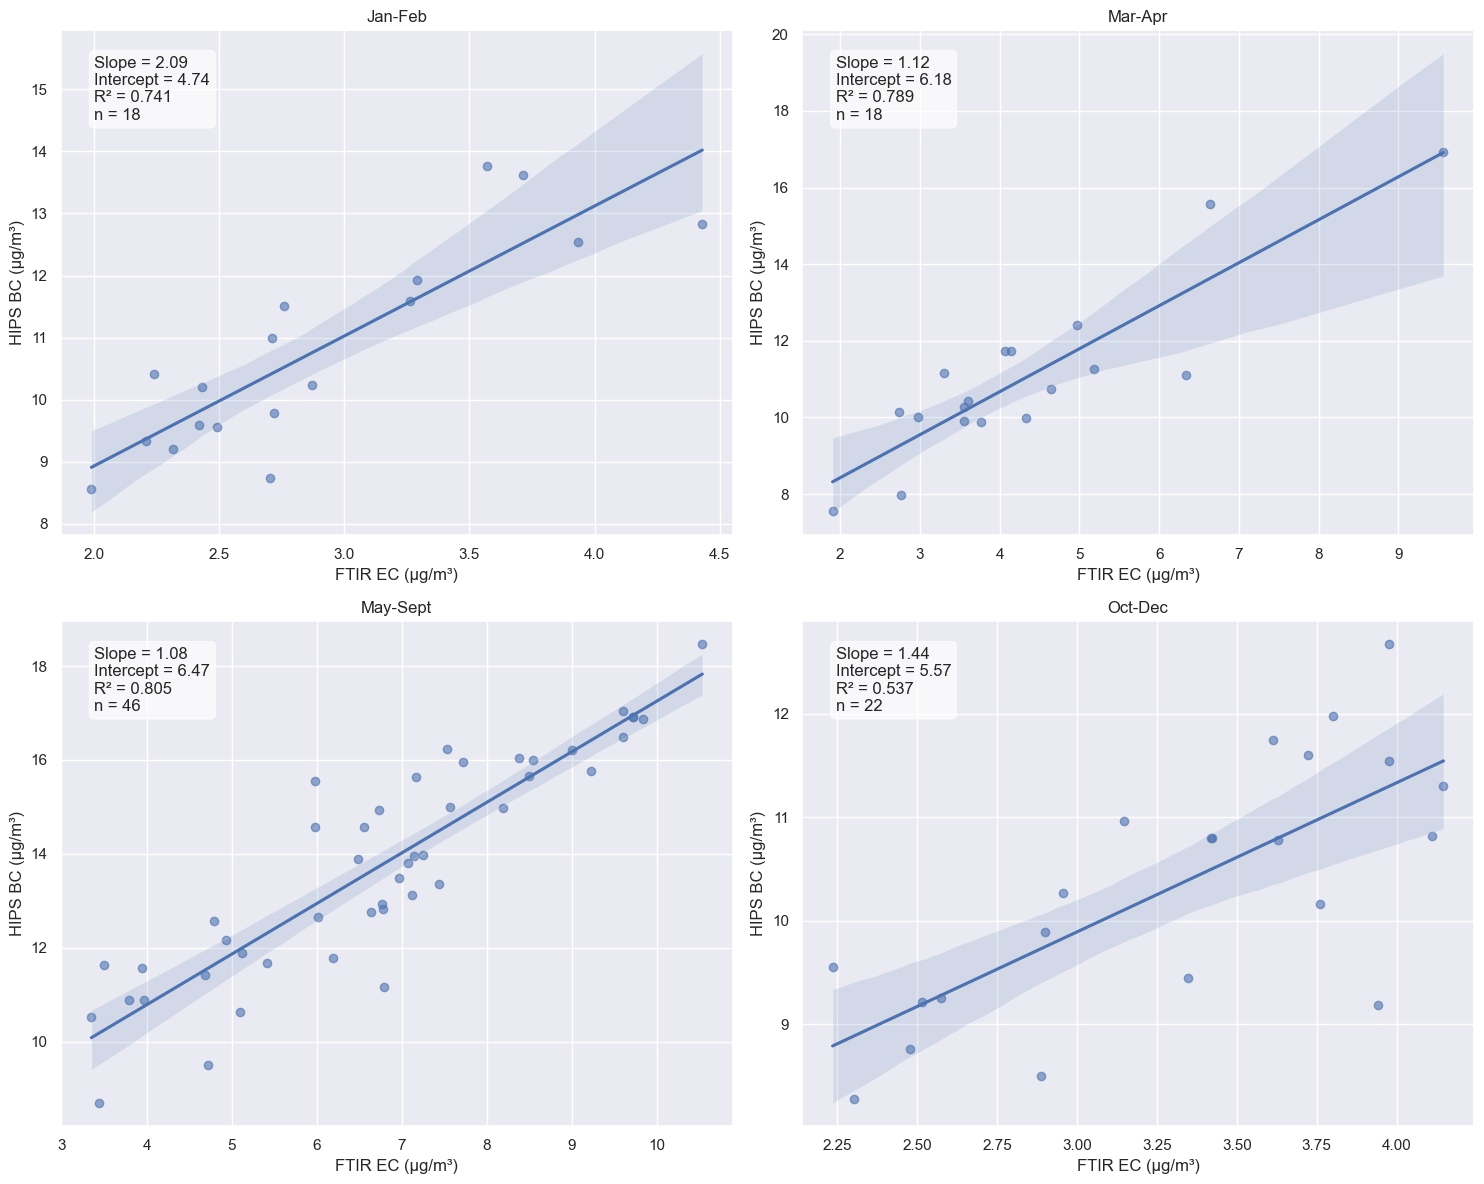

In [11]:
# Perform seasonal analysis
seasonal_results = analyze_seasonal_data(clean_data, mac, output_dir)

# %% [markdown]
# ## Summary Statistics Generation

# %%
def generate_summary_stats(clean_data, mac, regression_results):
    """Generate comprehensive summary statistics"""
    print("Generating summary statistics...")
    
    # Calculate BC values
    data_for_summary = clean_data.copy()
    data_for_summary['BC_HIPS'] = convert_fabs_to_bc(data_for_summary['Fabs'], mac)
    
    # Calculate residuals
    data_for_summary['Residuals'] = data_for_summary['BC_HIPS'] - data_for_summary['FTIR_EC']
    
    # Create a summary DataFrame
    summary = pd.DataFrame({
        'Metric': [
            'Sample Size',
            'MAC Value (m²/g)',
            'R-squared',
            'FTIR EC Mean (μg/m³)',
            'HIPS BC Mean (μg/m³)',
            'FTIR EC Std. Dev.',
            'HIPS BC Std. Dev.',
            'Mean Bias (BC-EC)',
            'Mean Absolute Error',
            'Root Mean Square Error'
        ],
        'Value': [
            len(data_for_summary),
            mac,
            regression_results['r_squared'],
            data_for_summary['FTIR_EC'].mean(),
            data_for_summary['BC_HIPS'].mean(),
            data_for_summary['FTIR_EC'].std(),
            data_for_summary['BC_HIPS'].std(),
            data_for_summary['Residuals'].mean(),
            data_for_summary['Residuals'].abs().mean(),
            np.sqrt((data_for_summary['Residuals']**2).mean())
        ]
    })
    
    display(summary)
    return summary

## Generate Summary Statistics
 
Use this cell to generate and display comprehensive summary statistics.

In [12]:
# Generate summary statistics
summary_stats = generate_summary_stats(clean_data, mac, regression_results)

Generating summary statistics...


,Metric,Value
0,Sample Size,104.000000
1,MAC Value (m²/g),4.018184
2,R-squared,0.817343
3,FTIR EC Mean (μg/m³),4.946447
4,HIPS BC Mean (μg/m³),12.060643
5,FTIR EC Std. Dev.,2.268399
6,HIPS BC Std. Dev.,2.509095
7,Mean Bias (BC-EC),7.114196
8,Mean Absolute Error,7.114196
9,Root Mean Square Error,7.193793


## Save Results
 
Use this cell to save your processed data and summary statistics.

In [ ]:
# Create output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save summary statistics to CSV
summary_stats.to_csv(os.path.join(output_dir, 'summary_statistics.csv'), index=False)

# Save processed data with BC values to CSV
clean_data_with_bc.to_csv(os.path.join(output_dir, 'processed_hips_data.csv'))

print(f"Analysis complete. Results saved to {output_dir}")

## Additional Analysis